In [ ]:
#| default_exp learner

In [ ]:
#| hide
# from torch.utils.data import DataLoader,default_collate
# import torchvision.transforms.functional as TF
# Huggingface
# from datasets import load_dataset,load_dataset_builder
# Own package
# from miniai.datasets import *

In [ ]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

Using cuda


In [ ]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
logging.disable(logging.WARNING)

## Learner

### Load and process data

Huggingface `datasets` package: [documentation](https://huggingface.co/docs/datasets/index)

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
bs = 1024
tds = dsd.with_transform(transformi)

In [ ]:
# Deleted on Jan 27 pull
# class DataLoaders:
#     def __init__(self, *dls): self.train,self.valid = dls[:2]

#     @classmethod
#     def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
#         """from data dictionaries"""
#         return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds), **kwargs) for ds in dd.values()])

```python
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

~/projects/fastai/course22p2/miniai/datasets.py
```

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): 
        """Save all arguments: model, dataloaders, loss function, lr, optimizer in learner object"""
        fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): 
            self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
        # mean cummulative loss and accuracy for the epoch
    
    def fit(self, n_epochs):
        """Main training loop"""
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(train=True)
            with torch.no_grad(): self.one_epoch(train=False)

In [ ]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(2)

0 True 1.1753059895833333 0.5986166666666667
0 False 1.1203779017857143 0.6133857142857143
1 True 0.9330483173076923 0.6741538461538461
1 False 0.9119745535714285 0.6808785714285714


## Basic Callbacks Learner

In [ ]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [ ]:
#|export
class Callback(): order = 0

In [ ]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

> `attrgetter`
> ```python
> attrgetter(attr, ...) --> attrgetter object
> 
> Return a callable object that fetches the given attribute(s) from its operand.
> 
> After f = attrgetter('name'), the call f(r) returns r.name.
> After g = attrgetter('name', 'date'), the call g(r) returns (r.name, r.date).
> After h = attrgetter('name.first', 'name.last'), the call h(r) returns (r.name.first, r.name.last).
> ```

Super simple callback for illustration

In [ ]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

Explore the `run_cbs` function:

In [ ]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 3 batches


In [ ]:
class ProgressLogCB(Callback):
    def before_fit(self, learn): 
        self.count = 0
        print('before_fit', self.count)
    def after_batch(self, learn): 
        self.count += 1
        print('after batch', self.count)
    def after_fit(self, learn): 
        print(f'Completed {self.count} batches')

In [ ]:
cbs = [ProgressLogCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

before_fit 0
after batch 1
after batch 2
after batch 3
after batch 4
Completed 4 batches


In [ ]:
cb = ProgressLogCB()
method_1 = getattr(cb, 'before_fit', None)
method_2 = getattr(cb, 'after_batch', None)
method_3 = getattr(cb, 'after_fit', None)
method_4 = getattr(cb, 'unknown_method', None)
display(method_1, method_2, method_3, method_4, cb.order)
method_1(learn)
method_2(learn)
method_3(learn)

<bound method ProgressLogCB.before_fit of <__main__.ProgressLogCB object>>

<bound method ProgressLogCB.after_batch of <__main__.ProgressLogCB object>>

<bound method ProgressLogCB.after_fit of <__main__.ProgressLogCB object>>

None

0

before_fit 0
after batch 1
Completed 1 batches


Learner with the callbacks

In [ ]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): 
        fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)  # set model in training or not training mode
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): 
        run_cbs(self.cbs, method_nm, self) # last self to give access to learner calling the cb from within the cb

#### Experiment with `run_cbs`

In [ ]:
import pdb

def my_run_cbs(cbs, method_nm, learn=None, trace=False):
    print('my_run_cbs')
    if trace: pdb.set_trace()
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None:
            if isinstance(cb, Callback): method()
            else: method(learn)

def my_callback(self, method_nm): 
    my_run_cbs(self.cbs, method_nm, self)

In [ ]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
model = get_model()
my_learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
my_learn.callback = my_callback

In [ ]:
cb = CompletionCB()
loattrs = [attr for attr in dir(cb) if not attr.startswith('_')]
print(loattrs)

run_cbs([cb], 'before_fit', learn=my_learn)
print(cb.count)

for n in range(3):
    run_cbs([cb], 'after_batch', learn=my_learn)
    print(cb.count)

run_cbs([cb], 'after_fit', learn=my_learn)
print(cb.count)

['after_batch', 'after_fit', 'before_fit', 'order']
0
1
2
3
Completed 3 batches
3


In [ ]:
class OtherCB(Callback):
    order = 1
    def blabla(self, *args): 
        print('blabla has run')
        print(args)
        return 10
cb2 = OtherCB()
cb2.blabla('bla', 2, 1019, my_learn), cb2.order

blabla has run
('bla', 2, 1019, <__main__.Learner object>)


(10, 1)

In [ ]:
cbs = [cb2, cb]
sorted(cbs, key=attrgetter('order'))

[<__main__.CompletionCB>,
 <__main__.OtherCB>]

In [ ]:
my_run_cbs(cbs, 'blabla', learn=my_learn, trace=False)
# my_run_cbs(cbs, 'blabla', learn=my_learn, trace=True)

my_run_cbs
blabla has run
()


#### end experiment

In [ ]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


Can use the dedicated exception to stop training early

In [ ]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [ ]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), ProgressLogCB()])
learn.fit(1)

before_fit 0
after batch 1


Now we can make the Learner make things more interesting, but only by using callbacks, not by changing the code !

## Metrics

In [ ]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

We overwrite the Metric class method `calc` to evaluate the various metrics, e.g. accuracy

In [ ]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [ ]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [ ]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

#### Unclear - TO BE REVIEWED

> Note 1: in the run_cbs function (used in learning to call cbs), we can refer to the learner within run_cbs
```python
    def run_cbs(cbs, method_nm, learn=None):
        for cb in sorted(cbs, key=attrgetter('order')):
            method = getattr(cb, method_nm, None)
            if method is not None:
                if isinstance(cb, SimpleCB): method()
                else: method(learn)
```
> This means that each callback function has an attribute `learn` that is the Learner's `self`, that is the learner/
> 
> Within the callback, `self.learn` is actually the instance of the learner

> Note 2: Device callback to handle the gpu and cpu in a smoother way:

Smart callback class that catches up undefined methods

In [ ]:
# class CallbackCatchMethods(SimpleCB):
#     order = 0
#     _fwd = 'model opt batch epoch'.split()

#     def __getattr__(self, name):
#         """Catches methods in _fwd and returns the same method in self.learn, i.e. the learner calling the callback"""
#         if name in self._fwd: return getattr(self.learn, name)
#         raise AttributeError(name)
    
#     def __setattr__(self, name, val):
#         if name in self._fwd: warn(f'Setting {name} in callback. Did you mean to set `self.learn.{name}`?')
#         super().__setattr__(name, val)
    
#     @property
#     def training(self): return self.model.training

In [ ]:
# #|export
# class DeviceCB(CallbackCatchMethods):
#     def before_fit(self): self.learn.model.to(def_device)
#     def before_batch(self): self.learn.batch = to_device(self.learn.batch)

Save the default device in the callback class as self.def_device

In [ ]:
# class DeviceCB(CallbackCatchMethods):
#     def __init__(self, device=def_device): fc.store_attr()
#     def before_fit(self, *args, **kwargs): self.learn.model.to(self.device)
#     def before_batch(self): self.learn.batch = to_device(self.learn.batch, device=self.device)

In [ ]:
# def_device

In [ ]:
# cb = DeviceCB(device=def_device)
# cb.device

In [ ]:
# from pdb import set_trace

In [ ]:
# %%time
# # using CPU (pass cpu to the device callback)
# model = get_model()
# learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(device='cpu'), CompletionCB()])
# learn.fit(1)

In [ ]:
# %%time
# # using GPU (pass cuda to the device callback)

# model = get_model()
# learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(device='cuda'), CompletionCB()])
# learn.fit(1)

 https://youtu.be/GNAE6K228ck?t=1266

## Torch implementation of metrics


`pip install torcheval`

Documentation [here](https://pytorch.org/torcheval/stable/)

In [ ]:
#|export
from torcheval.metrics import MulticlassAccuracy, MulticlassRecall, Mean

In [ ]:
metric = MulticlassAccuracy(average='micro', num_classes=4)
metric.update(input=tensor([0, 2, 1, 3]), target=tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

After reset, there is no data accumulated and computing the metric does not mean anything

In [ ]:
metric.reset()
metric.compute()

tensor(nan)

In [ ]:
metric = MulticlassAccuracy(average=None, num_classes=4)
metric.update(input=tensor([0, 2, 1, 3]), target=tensor([0, 1, 2, 3]))
metric.compute()

tensor([1., 0., 0., 1.])

Build a Metric Callback to print the metric.

Jeremy Howard realized that the metrics from `torcheval` do not work properly when on the GPU, so we have this `to_cpu` function to detach the gradient from the tensor and then puts it on the CPU. It works for dict, list and tuples.

In [ ]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [ ]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        """Takes the passed metrics, saves them. When metric is passed with as a kw arg, kw used as metric name"""
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    
    def before_fit(self, learn): 
        """Creates a reference for the learner to find the current instance of the MetricCB"""
        learn.metrics = self
    
    def before_epoch(self, learn): 
        """Reset all metrics at the start of each epoch"""
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        """Create a dict with metric aggregrated value over epoch, + epoch nbr and train/eval, then log it"""
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        """Grabs the predictions and the targets then update the metric data"""
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [ ]:
model = get_model()

# pass one metric as kw argument where the kw is the metric name
metrics = MetricsCB(accuracy=MulticlassAccuracy())

learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(3)

{'accuracy': '0.596', 'loss': '1.167', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.729', 'loss': '0.794', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.743', 'loss': '0.710', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.764', 'loss': '0.654', 'epoch': 1, 'train': 'eval'}
{'accuracy': '0.778', 'loss': '0.615', 'epoch': 2, 'train': 'train'}
{'accuracy': '0.799', 'loss': '0.575', 'epoch': 2, 'train': 'eval'}


In [ ]:
model = get_model()

# Pass several metrics as kw arguments
metrics = MetricsCB(accuracy=MulticlassAccuracy(), recall=MulticlassRecall())

learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.617', 'recall': '0.617', 'loss': '1.168', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.678', 'recall': '0.678', 'loss': '0.929', 'epoch': 0, 'train': 'eval'}


In [ ]:
model = get_model()

# Pass several metrics as positional arguments, and names will be the metric class names
metrics = MetricsCB(MulticlassAccuracy(), MulticlassRecall())

learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'MulticlassAccuracy': '0.618', 'MulticlassRecall': '0.618', 'loss': '1.140', 'epoch': 0, 'train': 'train'}
{'MulticlassAccuracy': '0.702', 'MulticlassRecall': '0.702', 'loss': '0.793', 'epoch': 0, 'train': 'eval'}


## Context Manager (simple syntax)

```python
@contextmanager
def my_context_manager_name(nm):
    context manager code run before own code 
    yield
    context manager code run after own code

with my_context_manager_name('fit'):
    own code
```

In [ ]:
@contextmanager
def my_context_manager(name):
    print(f"1. starting context manager with name: {name}")
    print(f"   next line of code is first line of own code within `with` statement")
    yield
    print(f"   previous line of code is last line of own code within `with` statement")
    print(f"2. ending context manager with name: {name}")

with my_context_manager('this_is_my_name') as cm:
    for l in 'abcde':
        print(f'   -> print letter {l}')

1. starting context manager with name: this_is_my_name
   next line of code is first line of own code within `with` statement
   -> print letter a
   -> print letter b
   -> print letter c
   -> print letter d
   -> print letter e
   previous line of code is last line of own code within `with` statement
2. ending context manager with name: this_is_my_name


`predict`, `get_loss`, `backward`, `step`, `zero_grad` are not defined in the class.

But when one of these method is called with `self.predict()`, and it does not find the `def predict(self)`, it will call `__getattr__()` with the corresponding name. See mechanism below

In [ ]:
class MyDummyClass:
    def __init__(self, val=0):
        fc.store_attr()
        
    def p(self):
        print(self.val)
    
    def pp(self):
        print(self.val * 10)
        
    def play(self):
        self.blabla()
        
    def default_fctn(self, arg):
        print(f'the default function was called with argument {arg}')
        
    def __getattr__(self, name):
#         pdb.set_trace()
        if '__' not in name:
            print(f"attr name <{name}> was passed to __getattr__ ")
        if name in ('blabla', 'brol'): 
            return partial(self.default_fctn, arg=name)
        raise AttributeError(name)

mdc = MyDummyClass(val=10)
mdc.p()
mdc.pp()
mdc.blabla()
mdc.brol()
# mdc.wrong_method()

10
100
attr name <blabla> was passed to __getattr__ 
the default function was called with argument blabla
attr name <brol> was passed to __getattr__ 
the default function was called with argument brol


The code below is actually making a call to `callback` with name 'predict','get_loss','backward','step' or 'zero_grad', if the corresponding method is called:


```python
def __getattr__(self, name):
    if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
    raise AttributeError(name)
```

## Flexible learner

Refactor the code of the Learner to have less lines of code, 
- putting the handling of the callback as one single block, by using a context manager. It helps avoid writing several time the `try: self,.callback(...)`
- calling methods (`self.predict(), self.get_loss()`) instead of `self.model(batch[0])` so that we can make the code more general and define the prediction and loss code separately. 


In [ ]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

The callbacks for training in `TrainCB`.

In this callback class, the code refers to `self.learn.preds`, instead of `self.preds`, because we are in the Callback class, not the Learner class. But Callback has this internal reference to the Learner object under `self.learn`

In [ ]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

NB: I added `self.n_inp` after the lesson. This allows us to train models with more than one input or output.

> fastprogress bars: [documentation](https://fastprogress.fast.ai/)

In [ ]:
from time import sleep

mb = master_bar(range(3))

for i in mb:
    for j in progress_bar(range(10), parent=mb):
        sleep(0.1)
        mb.child.comment = f'second bar stats'
    mb.main_bar.comment = f'first bar stats'
    mb.write(f'Finished loop {i}.')

In [ ]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [ ]:
model = get_model()

accuracy,loss,epoch,train
0.610,1.169,0,train
0.734,0.761,0,eval


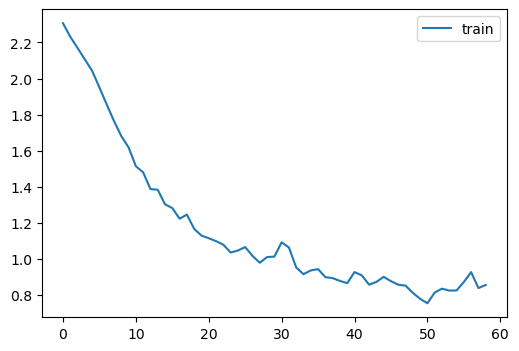

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## Updated versions since the lesson

After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore we've replaced the context manager with a decorator in this updated version of `Learner`. We have also added a few more callbacks in `one_epoch()`.

In [ ]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [ ]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.619,1.160,0,train
0.689,0.875,0,eval


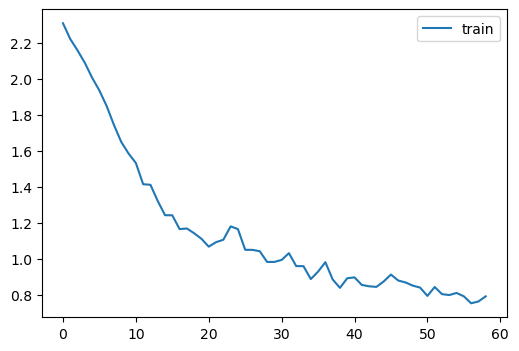

In [ ]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainLearner and MomentumLearner

In [ ]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In subclass `MomentumLearner`, we do not zero the gradients after each epoch, we scale them down by a factor `mom`. This means it will keep memory of the previous gradients (EMA), which turns out to be a momentum accumulation rule added on the plain vanilla SGD. It should improve the training performance within the same number of epochs

In [ ]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.684,0.940,0,train
0.796,0.574,0,eval


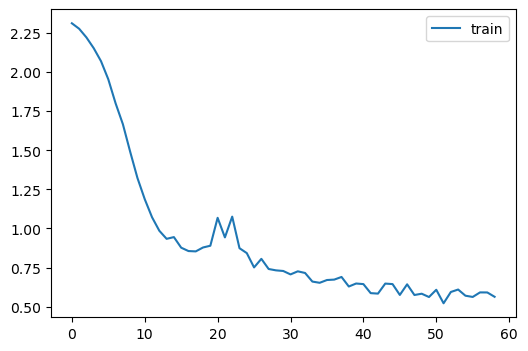

In [ ]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        # learning rates are stored in self,opt.param_groups dict
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

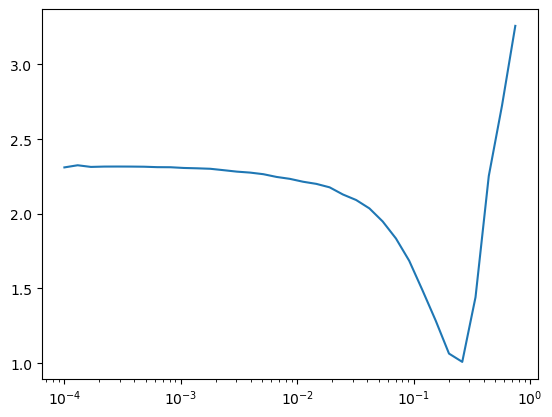

In [ ]:
# need to instanciate the finder callback first so that we can grab its attributes (lr and losses) after fitting
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [ ]:
 lrfind.min, lrfind.lrs[-3:], lrfind.losses[-4:]

(tensor(1.01),
 [0.44277926377684124, 0.5756130429098937, 0.7482969557828618],
 [tensor(1.44), tensor(2.25), tensor(2.73), tensor(3.26)])

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

In [ ]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*self.max_mult:
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

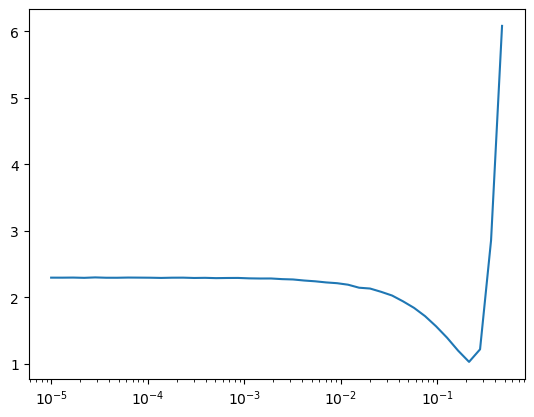

In [ ]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [ ]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

`lr_find` was added in lesson 18. It's just a shorter way of using `LRFinderCB`.

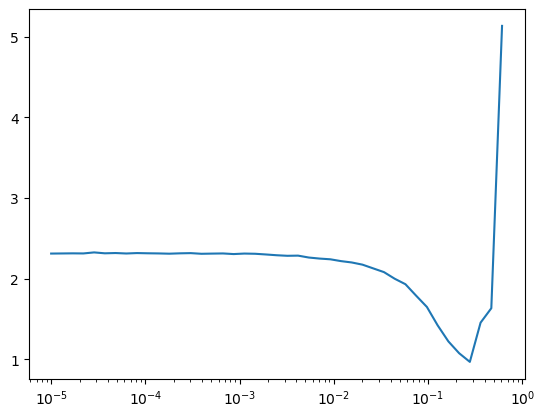

In [ ]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()